# Federated collaborative filtering 

Your task is to implement federated collaborative filterng model for privacy-preserving personalized recommendation system.  
In the Federated Learning paradigm, a master machine learning model is distributed to user clients, the clients use their locally stored data and model for both inference and calculating model updates. The model updates are sent back and aggregated on the server to update the master
model then redistributed to the clients. In this paradigm, the user data never leaves the client, greatly enhancing the user’ privacy, in contrast to the traditional paradigm of collecting, storing and processing user data on a backend server beyond the user’s control. The federated updates to the model are based on a gradient approach. 

Specifically, the method defines three core components as below.
1. All the item factor vectors $y_i, i = 1, ... , M$ are updated on the server and then distributed to each client $u$.
2. The user factor vectors $x_u, u = 1, ... , N$ are updated locally on the client $u$, using the user $u$’s own data and the $y_i, i = 1, ... , M$ from the server.
3. The updates through the gradients $\delta y_{ui}$ are calculated for the item $i$ on each client $u$ and transmitted to the server where the gradients are aggregated to update $y_i$.

The cost function optimizing across all users $u$ and the items $i$ over the confidence levels $c_{ui}$ is then given as

$$J = \sum_u \sum_i c_{ui}(p_{ui} - x_u^T y_i)^2 + \lambda (\sum_u||x_u||^2 + \sum_i ||y_i||^2),$$
with a regularization parameter $\lambda$,
where 
$$p_{ui} = \begin{cases}  
1 & r_{ui} > 0,\\
0 & r_{ui} = 0
\end{cases}$$
 $$c_{ui} = 1 + \alpha r_{ui}$$

User factors are updated by directly solving an equation

$$ \frac{\partial J(x_u)}{\partial x_u} = 0 $$
Thus, we obtain the solution
$$ x_u = (YC^uY^T + \lambda I)^{-1}YC^up(u),$$
where $ C^u \in \mathbb{R}^{N \times N}$ is a diagonal matrix with $C_{ii}^u = c_{ui}$ and $p(u) \in \mathbb{R}^{N \times 1}$ contains the $p_{ui}$ values for the user $u$.

Item factors are updated on the master server as

$$ y_i = y_i - \gamma \frac{\partial J}{\partial y_i},$$

where gamma is gain parameter.

$$ \frac{\partial J}{\partial y_i} = -2 \sum_u f(u,i) +2 \lambda y_i, $$
where 
$$ f(u,i) = \left[ c_{ui}(p_{ui} - x_u^T y_i)\right]x_u.$$

To familiarise yourself with the method, read the paper https://arxiv.org/pdf/1901.09888.pdf


In [ ]:
!pip install ipypb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-9n5lgo2j/polara_1219486af7054d02adee3657f835d26d
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-9n5lgo2j/polara_1219486af7054d02adee3657f835d26d
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89470 sha256=7145640be9c94ceda4fc3f093386c4d1ccb8b8b8c2fec817461f6efcfd3e4fea
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0x2ru6d/wheels/d2/cf/bf/e1a3e49c4a733261d717fa4732eadf0303dabcc48ba694ad7a
Successfull

In [ ]:
from scipy.sparse import csr_matrix
from ipypb import irange

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import diags
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from polara import get_movielens_data
from polara.evaluation.pipelines import random_grid, find_optimal_config

## Download dataset

For this task we will use popular MovieLens dataset.

In [ ]:
data = get_movielens_data(
    get_genres=False, # we won't need genres
    split_genres=False,
    include_time=True
)

data.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 1. Preprocess data  (5 pts)
Do the preprocessing, including data split and index transformation. You are recommended to use functions from the seminar on evaluation.

## Data split 


Split data to train/validation/test datasets, using leave-last-out scheme for holdout sampling.

In [ ]:
def leave_last_out(data, userid='userid', timeid='timestamp'):
    data_sorted = data.sort_values('timestamp')
    holdout = data_sorted.drop_duplicates(
        subset=['userid'], keep='last'
    ) # split the last item from each user's history
    remaining = data.drop(holdout.index) # store the remaining data - will be our training
    return remaining, holdout

In [ ]:
training_, holdout_ = leave_last_out(data)

In [ ]:
training_, holdout_val_ = leave_last_out(training_)

## Transform index

Transform index in train dataset and reindex validation and test datasets.

In [ ]:
def transform_indices(data, users, items):
    '''
    Reindex columns that correspond to users and items.
    New index is contiguous starting from 0.
    '''
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        data = data.assign(**{f'{field}': new_index}) # makes a copy of dataset!
    return data, data_index

def to_numeric_id(data, field):
    '''
    Get new contiguous index by converting the data field
    into categorical values.
    '''
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map

def reindex_data(data, data_index, fields=None):
    '''
    Reindex provided data with the specified index mapping.
    By default, will take the name of the fields to reindex from `data_index`.
    It is also possible to specify which field to reindex by providing `fields`.
    '''
    if fields is None:
        fields = data_index.keys()
    if isinstance(fields, str): # handle single field provided as a string
        fields = [fields]
    for field in fields:
        entity = data_index[field].name
        new_index = data_index[field].get_indexer(data[entity])
        data = data.assign(**{f'{entity}': new_index}) # makes a copy of dataset!
    return data

In [ ]:
train_data, data_index = transform_indices(training_, 'userid', 'movieid')

In [ ]:
test_data = reindex_data(holdout_, data_index)
val_data = reindex_data(holdout_val_, data_index)

In [ ]:
test_data = test_data.query('movieid >= 0')

In [ ]:
# sorting data by user id for correct evaluation
test_data = test_data.sort_values('userid') 
val_data = val_data.sort_values('userid')

In [ ]:
data_description = dict(
    users = data_index['users'].name, # user field
    items = data_index['items'].name, # item field
    test_users = test_data[data_index['users'].name].values,
    holdout_items = test_data[data_index['items'].name].values,
    val_users = val_data[data_index['users'].name].values,
    holdout_val_items = val_data[data_index['items'].name].values,
    n_users = train_data[data_index['users'].name].nunique(), 
    n_items = train_data[data_index['items'].name].nunique()
)

In [ ]:
data

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


# 2. Building/training a recommender model (20 pts)

## Preparing data in matrix form

Complete the function to obtain sparse matrix from training data.

In [ ]:
def matrix_from_observations(data, userid, itemid, feedback=None, shape=None, dtype=None):
    '''Return sparse matrix,/ obtained from training data'''
    useridx = train_data[userid].values
    itemidx = train_data[itemid].values
    feedback = train_data[feedback].values
    matrix = csr_matrix((feedback, (useridx, itemidx)), shape=shape, dtype = dtype)

    return matrix      

In [ ]:
data_matrix = matrix_from_observations(train_data, userid='userid', itemid='movieid', feedback='rating')
data_matrix

<6040x3704 sparse matrix of type '<class 'numpy.int64'>'
	with 988129 stored elements in Compressed Sparse Row format>

## The model

In [ ]:
n_users = data_description['n_users']
n_items = data_description['n_items']
n_factors = 50
seed = 42

In [ ]:
# initialization of user and item factors
random_state = np.random.RandomState(seed)
user_factors = random_state.normal(0, 0.01, size=(n_users, n_factors))
item_factors = random_state.normal(0, 0.01, size=(n_items, n_factors))

## Server side

Complete the functions to update item factors.


In [ ]:
def update_global_model(matrix, X, Y, regularization, gain, alpha, n_iter):
    for _ in range(n_iter):
        grad = item_factor_update(matrix, X, Y, regularization, alpha, n_iter)
        Y -= gain * grad  # update Y


def item_factor_update(matrix, X, Y, regularization, alpha, n_iter=4):
    '''Update item factor vectors'''
    n_users , _ = X.shape
    grad = 2*regularization*Y # initialize gradient as a regularization term
    for u in range(n_users):
        grad += 2*fetch_neg_client_grad(matrix, X, Y, u, alpha) # add calculated gradient for a user
    return grad
    

def fetch_neg_client_grad(matrix, X, Y, u, alpha):
    '''
    Fetches for entire item collection at once
    f(u, i) = c_ui * (p_ui - yi^T xu) xu
    f(u, Y) = C_u *  (p_u  -   Y xu ) xu^T = - (Y xu + (Cu-1)*(Yxu - pu)) xu^T
    '''
    indptr = matrix.indptr # get indptr from sparse matrix
    inds = matrix.indices[indptr[u]:indptr[u+1]] # get indices from sparse matrix
    r = matrix[u] # get ratings
    # print('r', r)
    # print(r.shape)

    xu = X[u][:,np.newaxis] # get user's vector

    # print('X[u]', X[u].shape)
    # print('xu', xu.shape)

    p_u = np.swapaxes(np.zeros(r.shape),0,1)
    # print('p_u.shape', p_u.shape)
    # print('p_u', p_u)

    p_u[inds[indptr[u]:indptr[u+1]]] = 1
    # print('p_u.shape', p_u.shape)
    # print('p_u', p_u)
    

    C_u = ((1+alpha*r.A).squeeze())
    # print(r.shape)    
    # print('C_u', C_u.shape)
    # print('p_u - Y @ xu', (p_u - Y @ xu).shape)
    # print('(p_u - Y @ xu).squeeze()', (p_u - Y @ xu).squeeze().shape)
    # print('(C_u * (p_u - Y @ xu).squeeze())[:,np.newaxis].shape', (C_u * (p_u - Y @ xu).squeeze())[:,np.newaxis].shape)
    # print('xu.T', xu.T.shape)

    user_neg_grad_val = (C_u * (p_u - Y @ xu).squeeze())[:,np.newaxis] @ (xu.T) # get negative gradient values for user 
    # print(user_neg_grad_val.shape)
    return user_neg_grad_val# negative gradient values for user

## Client side

Complete the functions to update user factors.

In [ ]:
from scipy.sparse import diags
from scipy import sparse

def update_local_models(matrix, X, Y, regularization, alpha):
    n_users, n_factors = X.shape
    YtY = Y.T @ Y + regularization * np.eye(n_factors)
    for u in range(n_users): # to imitate locally updating on the client side
        X[u] = user_factor_update(Y, YtY, matrix, u, alpha) # each client does independently


def user_factor_update(Y, YtY, matrix, u, alpha):
    '''
    Return the solution of equation
    Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
    '''
    A, b = solve_linear_equation(Y, YtY, matrix, u, alpha)
    # print('A', A.shape)
    # print('b', b.shape)

    return (np.linalg.inv(A) @ b).squeeze() # the solution of equation


def solve_linear_equation(Y, YtY, matrix, u, alpha):
    '''
    Return A = YtCuY + regularization * I and b = YtCuPu
    to use it later for solving the equation
    Xu = (YtCuY + regularization * I)^-1 (YtCuPu)

    Following identity might be helpful
    YtCuY + regularization * I = YtY + regularization * I + Yt(Cu-I)Y = YtY + Yt(Cu-I)Y
    '''
    indptr = matrix.indptr # get indptr from sparse matrix 
    inds = matrix.indices[indptr[u]:indptr[u+1]] # get indices from sparse matrix
    r = matrix.data[indptr[u]:indptr[u+1]] 
    # print('r', r)
    # print('r', r.shape)

    r = matrix[u] # get ratings 
    # print('r', r)
    # print('r', r.shape)

    pu = (r > 0).T * 1
    # print('pu', pu.shape)
    # print('pu', pu.toarray())

    p_u = np.zeros(r.shape)
    p_u[:, inds] = 1
    # print('p_u', p_u.shape)
    # print('p_u', p_u)

    # Cu_I = alpha*r
    # Cu = Cu_I.A+ np.ones_like(Cu_I.A)
    # print('Cu_I', Cu_I)
    # print('Cu_I', Cu_I.toarray().squeeze())
    # print('Cu', Cu.shape)
    # print('Cu', Cu)
    # print(diags(Cu.squeeze()).shape)
    # print(diags(Cu.squeeze()))
    # print('diags(Cu_I.toarray().squeeze()', diags(Cu_I.toarray().squeeze()).toarray().shape)

    alpha_r = (alpha * r).toarray().squeeze()
    Cu =  sparse.eye(np.shape(diags(alpha_r))[0]) + diags(alpha_r)
    # print('myCu', Cu.shape)
    # print('myCu', Cu)

    A = Y.T @ (diags(alpha_r))@ Y + YtY # accumulate YtCuY + regularization * I in A
    # print('A', A.shape)
    # print('A', A)
    b = Y.T @ Cu @ pu.toarray() # accumulate YtCuPu in b
    # print('b', b.shape)
    # print('b', b)

    # printx()
    return A, b 
    

## Model Training
Complete the function to build model. Choose the hyper-parameters and store it in config. Train your model on chosen hyper-parameters.

In [ ]:
def build_model(model_config, trainset, trainset_description):
    train_matrix = matrix_from_observations(trainset,
                           trainset_description['users'], trainset_description['items'], feedback = 'rating')# get sparse matrix
    # print(train_matrix.shape)
    random_state = np.random.RandomState(seed)
    user_factors = random_state.normal(0, 0.01, size=(trainset_description['n_users'], n_factors)) # initialize user factors
    # print(user_factors.shape)
    item_factors = random_state.normal(0, 0.01, size=(trainset_description['n_items'], n_factors))  # initialize user factors
    # print(item_factors.shape)
    n_epochs = model_config['n_epochs']

    for epoch in tqdm(range(n_epochs)):
       # in each epoch update global model and then update local models
       update_global_model(train_matrix, user_factors, item_factors, config['regularization'], config['gain'], config['alpha'], config['n_iter'])
       update_local_models(train_matrix, user_factors, item_factors, config['regularization'], config['alpha'])

            
    return user_factors, item_factors

In [ ]:
# create config with the following hyper parameters:
# seed, n_factors, regularization, gain, alpha, n_epochs, n_iter.
config = {'seed': seed , 'n_factors': 50 , 'regularization': 1, 
          'gain': 0.2, 'alpha': 1 , 'n_epochs': 10 , 'n_iter': 10}


In [ ]:
params = build_model(config, train_data, data_description) 

100%|██████████| 10/10 [23:03<00:00, 138.34s/it]


# 3. Evaluation (5 pts)

Complete the functions to predict relevance scores. Using predcted scores generate top-n recommendations. Evaluate quality of recommendations and report HR@5 and MRR@5 etrics. Remember that we don't want to recommend items from the user's history. You are recommended to use functions from the previous seminars.

In [ ]:
topn = 5

In [ ]:
# Complete model scoring function to predict relevance scores for test user-item pairs.
def model_scoring(model_params, testset, testset_description):
    user_factors, item_factors = model_params # get user and item factros
    test_user_factors = testset['userid'].unique() # get user factros for test users.  # random_state.normal(0, 0.01, size=(testset_description['n_users'], n_factors)) testset['userid'].unique() 
    scores = user_factors[test_user_factors] @ item_factors.T # get scores
    return scores

In [ ]:
def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [ ]:
# Complete model recommendations function to generate top-n recommendations using predcted scores.
def model_recom_func(model_scores, topn=5):
    recommendations = np.apply_along_axis(topidx, 1, model_scores, topn)
    return recommendations

In [ ]:
# Complete function to evaluate quality of recommendations
def evaluate_func(model_recoms, holdout, holdout_description, topn=5):
    # userid = holdout_description['users']
    # holdout_users = holdout[userid].values

    # assert model_recoms.shape[0] == len(holdout_users)

    #hits_mask = model_recoms[:, :topn] == holdout_users.reshape(-1, 1)

    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert model_recoms.shape[0] == len(holdout_items)
    hits_mask = model_recoms[:, :topn] == holdout_items.reshape(-1, 1)


    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))

    # MRR calculation
    n_test_items = model_recoms.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_items

    return hr, mrr

## Evaluate model

In [ ]:
userid = data_description['users']
seen_idx_mask = train_data[userid].isin(data_description['test_users'])
testset = train_data[seen_idx_mask]

In [ ]:
test_scores = model_scoring(params, testset, data_description) # get scores
recoms = model_recom_func(test_scores) # get recommended items
hr, mrr = evaluate_func(recoms, test_data, data_description) # get metrics
print(f'HR@{topn} = {hr:.4f}')
print(f'MRR@{topn} = {mrr:.4f}')

HR@5 = 0.0015
MRR@5 = 0.0013


# Quick check

Compare your model with one or two baselines and report the results. You can use code from previous seminars. 

In [ ]:
# HR@5 = 0.0015
# MRR@5 = 0.0013

# 4. Hyper-parameter selection (5 pts)

Complete the function to tune hyper-parameters of your model to provide the best quality. Train the model with the best hyper-parameters and report HR and MRR on test dataset.

In [ ]:
# you are free to change hp values
params_dict = dict(n_factors = [10, 20, 50, 100],
                  regularization = np.linspace(1, 5, 5).astype(int),
                  gain = np.logspace(-4, -2, 5),
                  alpha = np.linspace(1, 5, 5).astype(int),
                  n_epochs = [10, 15, 20, 25],
                  n_iter = np.linspace(4, 20, 5).astype(int))

In [ ]:
param_grid, param_names = random_grid(params_dict, n=2)

In [ ]:
param_names

('n_factors', 'regularization', 'gain', 'alpha', 'n_epochs', 'n_iter')

In [ ]:
for grid_params in tqdm(param_grid):
  lfm_config = dict(zip(param_names, grid_params))
print(lfm_config)

100%|██████████| 2/2 [00:00<00:00, 16513.01it/s]

{'n_factors': 100, 'regularization': 3, 'gain': 0.00031622776601683794, 'alpha': 1, 'n_epochs': 25, 'n_iter': 16}


In [ ]:
def hp_selection(data, description, param_grid, param_names, testset, test_data):
    ''' Return best HR value and best set of hyperparameters '''
    best_hr = 0
    for grid_params in tqdm(param_grid):
      lfm_config = dict(zip(param_names, grid_params))
      params = build_model(lfm_config, data, description) 
      test_scores = model_scoring(params, testset, description)
      recoms = model_recom_func(test_scores)
      hr, mrr = evaluate_func(recoms, test_data, description)
      if hr > best_hr:
        best_hr = hr
        best_params = params
        best_conf = lfm_config

    return best_hr, best_params, best_conf

In [ ]:
best_hr, best_params, lfm_config = hp_selection(train_data, data_description, param_grid, param_names, testset, test_data)

100%|██████████| 2/2 [1:21:34<00:00, 2447.49s/it]


In [ ]:
#best_hr, best_params, lfm_config = hp_selection(train_data, data_description, param_grid, param_names, testset, test_data)

 50%|█████     | 15/30 [11:05:51<11:05:51, 2663.43s/it]


KeyboardInterrupt: ignored

In [ ]:
best_params

(array([[-7.84594030e-26,  9.68023290e-28, -2.47368708e-26, ...,
         -8.29283840e-26, -5.31399006e-26, -7.72698628e-26],
        [ 2.18237816e-26, -6.34682778e-26,  2.77364653e-29, ...,
         -2.03951780e-26,  1.07493348e-25, -2.30100572e-25],
        [ 9.78433565e-26,  5.73165676e-27,  4.98979378e-26, ...,
          9.96869998e-26,  1.16899562e-26, -1.83847166e-25],
        ...,
        [-5.48753010e-27, -3.22151869e-26,  2.21406661e-26, ...,
          4.37701142e-27, -3.06802833e-26, -1.23351782e-25],
        [-4.20506083e-26, -1.63493566e-25, -1.23297125e-25, ...,
         -8.58814036e-26, -7.62770054e-26, -7.24494840e-26],
        [-5.19872905e-26, -2.63273915e-26,  4.13566272e-26, ...,
         -6.65132119e-26,  1.43269859e-25, -2.72452092e-25]]),
 array([[ 4.86302192e+26, -4.73653571e+26, -2.57819595e+26, ...,
         -9.80840129e+26,  1.90809834e+26,  5.11918361e+24],
        [-1.36925370e+22,  1.36634145e+22,  8.41451992e+21, ...,
          2.37033133e+22, -5.19755853e

In [ ]:
best_hr

0.0014905597880092746

In [ ]:
lfm_config

{'n_factors': 100,
 'regularization': 3,
 'gain': 0.00031622776601683794,
 'alpha': 4,
 'n_epochs': 10,
 'n_iter': 4}

In [ ]:
# Train the model with the best hyper-parameters and report HR and MRR on test dataset.
test_scores = model_scoring(best_params, testset, data_description)
recoms = model_recom_func(test_scores) # get recommended items
hr, mrr = evaluate_func(recoms, test_data, data_description)
print(f'HR@{topn} = {hr:.4f}')
print(f'MRR@{topn} = {mrr:.4f}')

HR@5 = 0.0015
MRR@5 = 0.0013


# 5. Analysis (5 pts) 

Examine how the loss function, $||X||$ and $||Y||$ change during the training. Complete the function to obtain the history of losses values, $||X||$ and $||Y||$ for every epoch. Use best hyper-parameters for model config. Plot the graphs and discuss the results.

In [ ]:
def get_loss(X, Y, regularization, matrix, alpha):
    for u in range(len(X)):
        xu = X[u]
        matr_u = matrix[u]
        pu = (matr_u > 0).T * 1
        Cu = diags(1 + alpha * matr_u.A.ravel())
        part_sum = np.sum(np.sum(Cu @ np.power(pu - Y @ xu.reshape(-1, 1), 2)))
    
    J = np.sum(part_sum) + regularization * (np.sum(np.linalg.norm(X, axis=1)**2) + np.sum(np.linalg.norm(Y, axis=1)**2))
    return J

def model_analysis(model_config, trainset, trainset_description):

    
    train_matrix = matrix_from_observations(trainset, userid='userid', itemid='movieid', feedback='rating') # get sparse matrix
    # matrix_from_observations_(trainset,
    #                                         trainset_description,
    #                                         rebase_users=False) # get sparse matrix

    n_users = trainset_description['n_users']
    n_items = trainset_description['n_items']

    random_state = np.random.RandomState(seed)
    user_factors = random_state.normal(0, 0.01, size=(n_users, n_factors))
    item_factors = random_state.normal(0, 0.01, size=(n_items, n_factors))
    
    X_norms = []
    Y_norms = []
    losses = []

    for epoch in tqdm(range(model_config["n_epochs"])):
        # in each epoch update global model and then update local models
        update_global_model(train_matrix, user_factors, item_factors,
                                model_config["regularization"],
                                model_config["gain"],
                                model_config["alpha"],
                                model_config["n_iter"])

        update_local_models(train_matrix, user_factors, item_factors,
                                model_config["regularization"],
                                model_config["alpha"])
        
        loss = get_loss(user_factors, item_factors, model_config["regularization"], train_matrix, model_config["alpha"])
        

        X_norms.append(np.linalg.norm(user_factors))
        Y_norms.append(np.linalg.norm(item_factors))
        
        losses.append(loss)
    
    return X_norms, Y_norms, losses

In [ ]:
X_norms, Y_norms, losses = model_analysis(lfm_config, train_data, data_description)

100%|██████████| 10/10 [15:28<00:00, 92.88s/it]


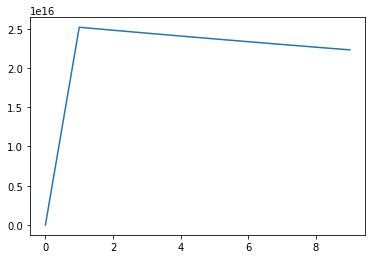

In [ ]:
# Plot the graphs and discuss the results.
plt.plot(range(lfm_config['n_epochs']), losses)

In [ ]:
plt.plot(range(lfm_config['n_epochs']), X_norms)

In [ ]:
plt.plot(range(lfm_config['n_epochs']), Y_norms)

What is the time complexity of the federated collaborative filterng with gradient descent? 